## Behaviour of xESMF when source grid includes ghost cells / halo

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import xesmf as xe
import scipy
import clisops.core as clore
import clisops as cl
print("Using roocs/clisops in version %s" % cl.__version__)
print("Using xESMF in version %s" % xe.__version__)

xr.set_options(display_style='html');

#import warnings
#warnings.simplefilter("ignore") 
#with warnings.catch_warnings():
#        warnings.simplefilter("ignore")

Using roocs/clisops in version 0.6.1
Using xESMF in version 0.5.3.dev11+gcb46501


In [2]:
# Define paths to the data
archive_root="/work/ik1017/CMIP6/data/CMIP6/"

path_mpiesmhr=archive_root+"CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/"
path_mpiesmhr=path_mpiesmhr+"Omon/tos/gn/v20190710/tos_Omon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_185001-185412.nc"

path_mpiesmlr=archive_root+"CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/"
path_mpiesmlr=path_mpiesmlr+"Omon/tos/gn/v20190710/tos_Omon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001-186912.nc"

path_cmcccm2=archive_root+"CMIP/CMCC/CMCC-CM2-SR5/historical/r1i1p1f1/"
path_cmcccm2=path_cmcccm2+"Omon/tos/gn/v20200616/tos_Omon_CMCC-CM2-SR5_historical_r1i1p1f1_gn_185001-201412.nc"

In [3]:
# Read the data with halo
ds_mpiesmhr_halo=xr.open_dataset(path_mpiesmhr).isel(time=0)
ds_mpiesmlr_halo=xr.open_dataset(path_mpiesmlr).isel(time=0)
ds_cmcccm2_halo=xr.open_dataset(path_cmcccm2).isel(time=0)

# Read the data without halo
ds_mpiesmhr=xr.open_dataset(path_mpiesmhr).isel(time=0).isel(i=slice(1, 801), j=slice(2,405)).squeeze()
ds_mpiesmlr=xr.open_dataset(path_mpiesmlr).isel(time=0).isel(i=slice(1, 255)).squeeze()
ds_cmcccm2=xr.open_dataset(path_cmcccm2).isel(time=0).isel(i=slice(1, 292), j=slice(1,361)).squeeze()

### Plot the grid

In [4]:
import textwrap
def plot_curv_grid(ds, var="tos"):    
        lat=cfxr.accessor._get_with_standard_name(ds, "latitude")[0]
        lon=cfxr.accessor._get_with_standard_name(ds, "longitude")[0]        
        if any([i==None for i in [lat, lon]]): 
            print(ds.attrs["source_id"],": Cannot identify latitude/longitude.")
            return
        plt.figure(figsize=(16, 9), dpi=120)
        plt.scatter(x=ds[lon], y=ds[lat], s=0.01)
        #x,y=np.meshgrid(ds[lon], ds[lat])
        #plt.scatter(x=x, y=y, s=0.01)
        try:
            plt.title("\n".join(textwrap.wrap(ds.attrs["source_id"] + "("+ds.attrs["source"].split("ocean:")[-1].split("\n")[0]+")", 120)))
        except (KeyError, IndexError):
            plt.title(ds.attrs["source_id"])   

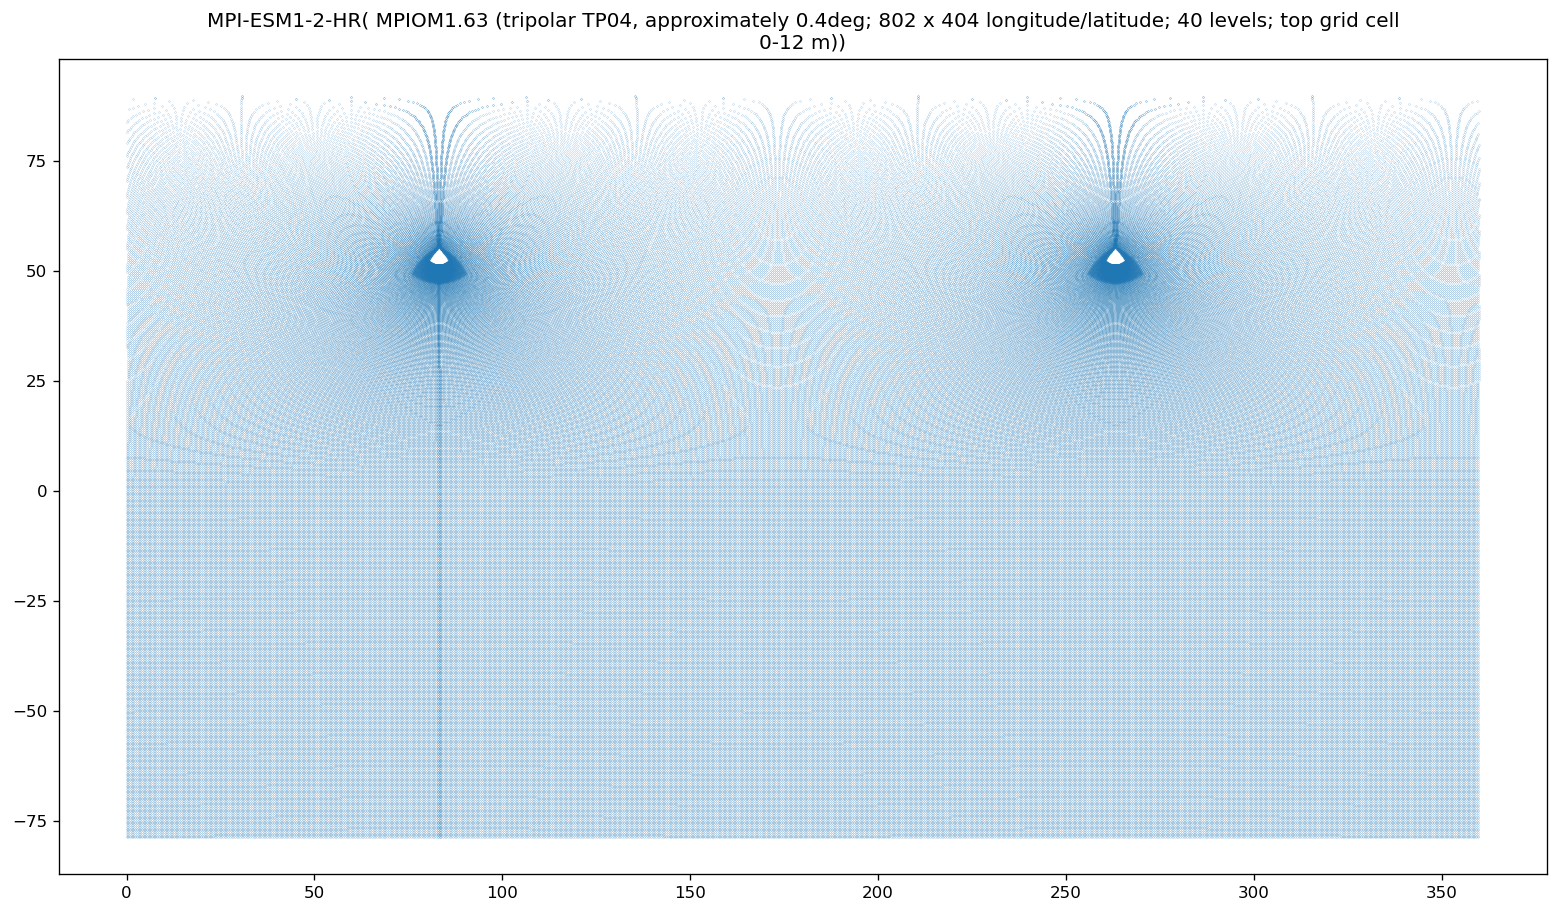

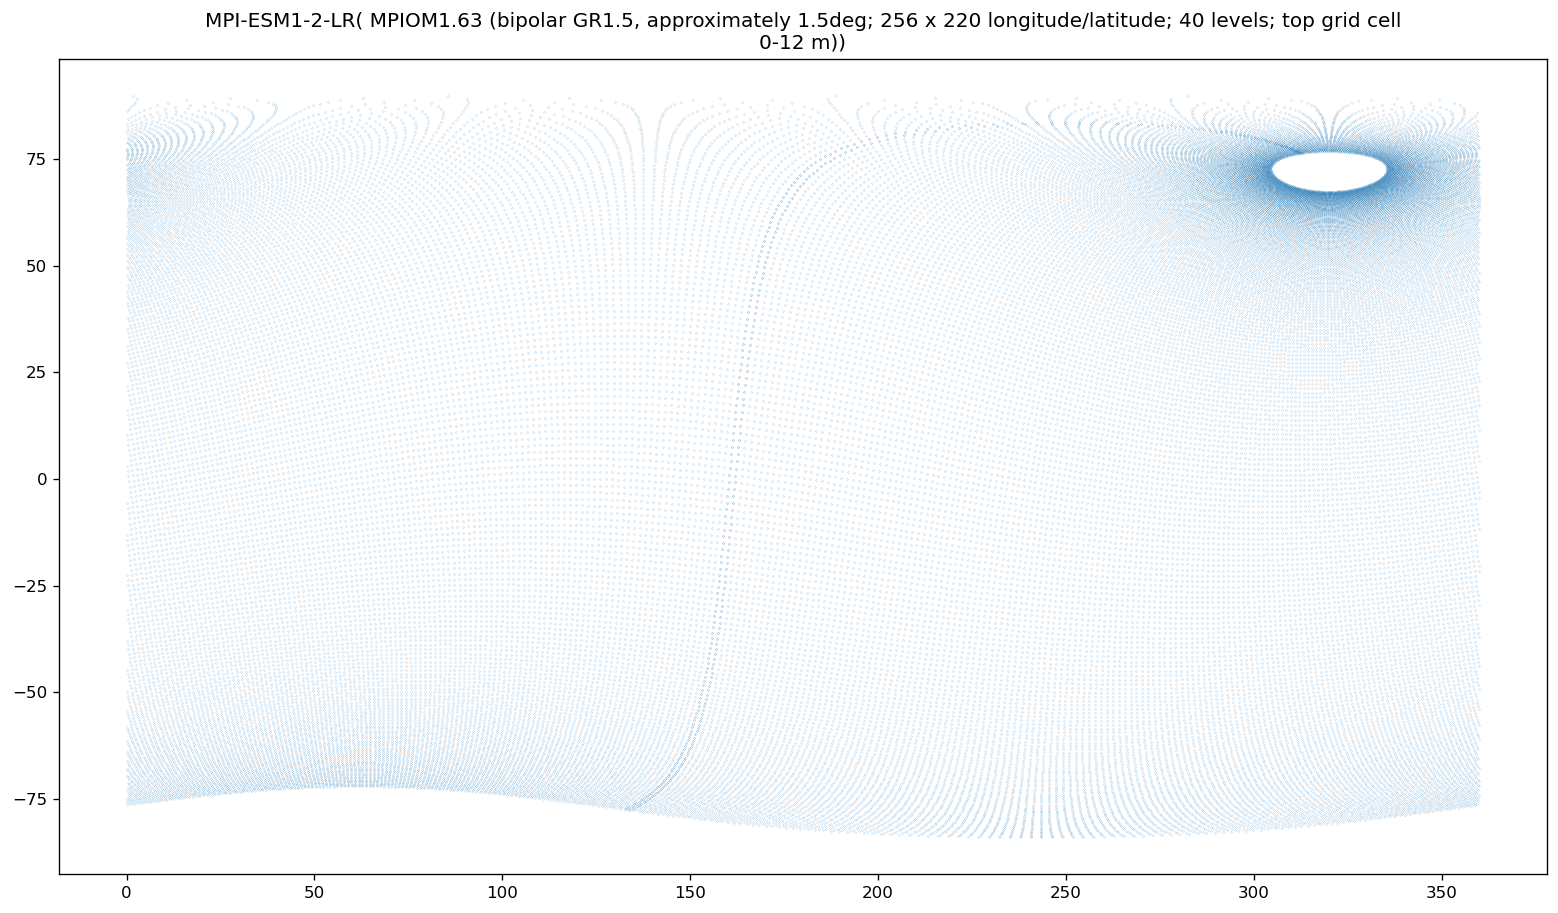

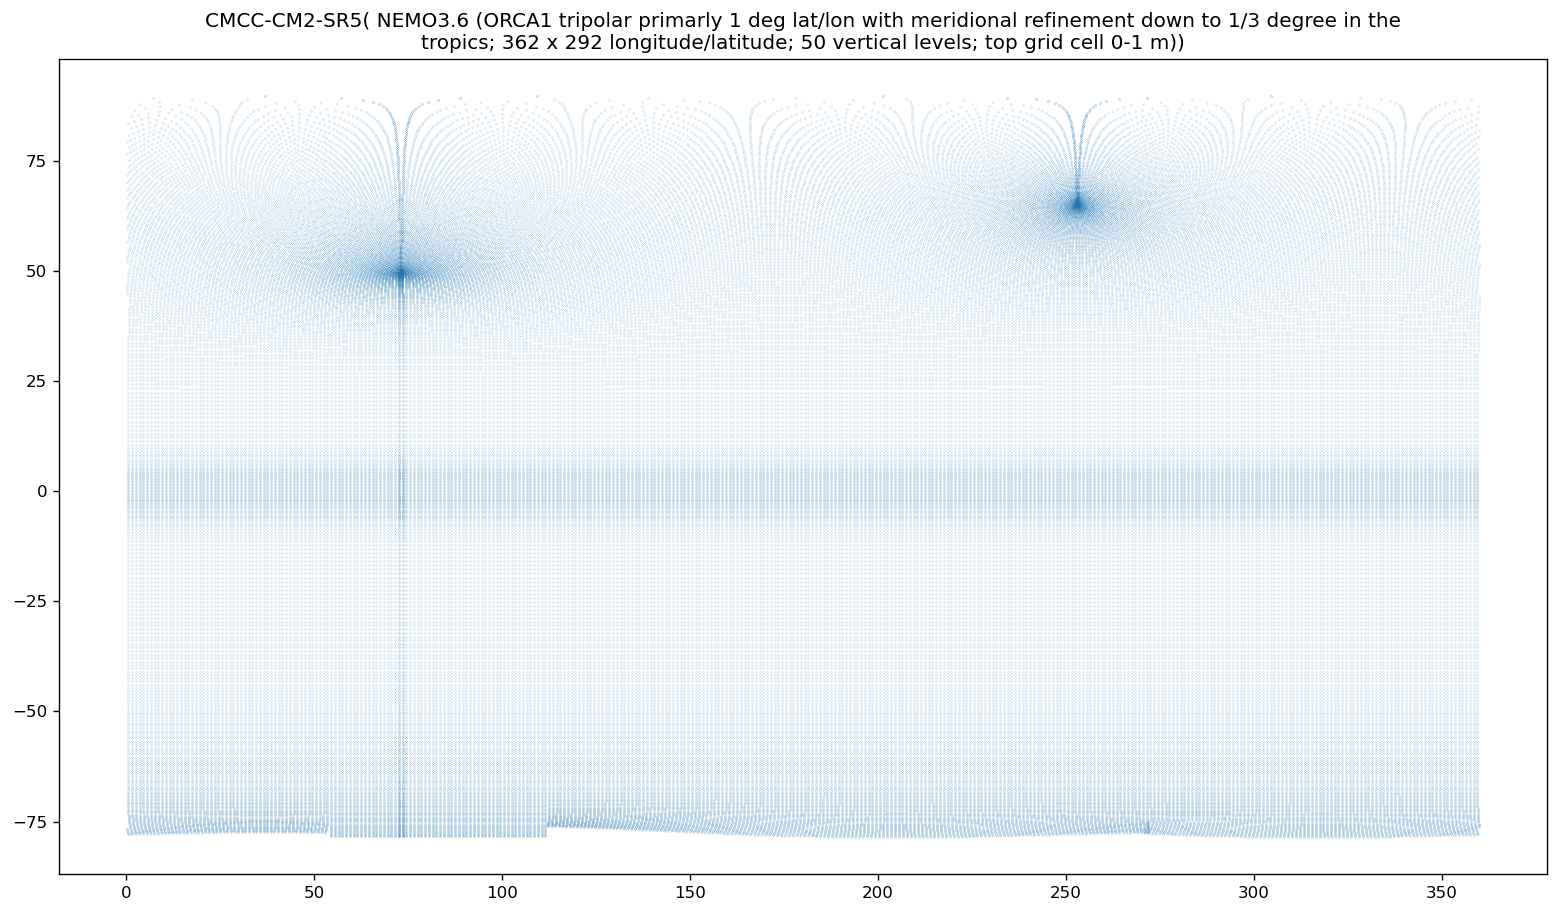

In [5]:
plot_curv_grid(ds_mpiesmhr_halo)
plot_curv_grid(ds_mpiesmlr_halo)
plot_curv_grid(ds_cmcccm2_halo)

### Specify output grid and generate the remapping weights

In [6]:
# Specify a global 1deg target grid
ds_out=clore.Grid(grid_instructor=(1.,)).ds

In [7]:
# In case of problems, activate ESMF verbose mode
import ESMF
ESMF.Manager(debug=True)

# Regridding methods
method_list = ['nearest_s2d', 'bilinear', 'patch', 'conservative']

# Function to generate the weights
#   If grids have problems of degenerated cells near the poles there is the ignore_degenerate option
def regrid(ds_in, ds_out, method, periodic, ignore_degenerate=None):
    """Convenience function for calculating regridding weights"""
    return xe.Regridder(ds_in, ds_out, method, periodic=periodic, ignore_degenerate=ignore_degenerate) 

In [8]:
# Generating the weights for all specified methods
regridder_mpiesmlr_halo={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-LR", method)
    %time regridder_mpiesmlr_halo[method]=regrid(ds_mpiesmlr_halo, \
                                                 ds_out, method, \
                                                 periodic=True, \
                                                 ignore_degenerate=None)

-------------
MPI-ESM-1-2-LR nearest_s2d
CPU times: user 415 ms, sys: 34 ms, total: 449 ms
Wall time: 444 ms
-------------
MPI-ESM-1-2-LR bilinear
CPU times: user 4.73 s, sys: 583 ms, total: 5.31 s
Wall time: 5.31 s
-------------
MPI-ESM-1-2-LR patch
CPU times: user 40.4 s, sys: 865 ms, total: 41.3 s
Wall time: 41.2 s
-------------
MPI-ESM-1-2-LR conservative


ValueError: ESMC_FieldRegridStore failed with rc = 506. Please check the log files (named "*ESMF_LogFile").

In [9]:
# Generating the weights for all specified methods
regridder_mpiesmhr_halo={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-HR", method)
    %time regridder_mpiesmhr_halo[method]=regrid(ds_mpiesmhr_halo, \
                                                 ds_out, method, \
                                                 periodic=True, \
                                                 ignore_degenerate=None)

-------------
MPI-ESM-1-2-HR nearest_s2d
CPU times: user 1.05 s, sys: 62 ms, total: 1.11 s
Wall time: 1.11 s
-------------
MPI-ESM-1-2-HR bilinear


ValueError: ESMC_FieldRegridStore failed with rc = 506. Please check the log files (named "*ESMF_LogFile").

-------------
MPI-ESM-1-2-HR patch


ValueError: ESMC_FieldRegridStore failed with rc = 506. Please check the log files (named "*ESMF_LogFile").

-------------
MPI-ESM-1-2-HR conservative


ValueError: ESMC_FieldRegridStore failed with rc = 506. Please check the log files (named "*ESMF_LogFile").

In [10]:
# Generating the weights for all specified methods
regridder_cmcccm2_halo={}
for method in method_list:
    print("-------------\nCMCC-CM2-SR5", method)
    %time regridder_cmcccm2_halo[method]=regrid(ds_cmcccm2_halo, \
                                                ds_out, method, \
                                                periodic=True, \
                                                ignore_degenerate=None)

-------------
CMCC-CM2-SR5 nearest_s2d
CPU times: user 597 ms, sys: 32 ms, total: 629 ms
Wall time: 626 ms
-------------
CMCC-CM2-SR5 bilinear


ValueError: ESMC_FieldRegridStore failed with rc = 506. Please check the log files (named "*ESMF_LogFile").

-------------
CMCC-CM2-SR5 patch


ValueError: ESMC_FieldRegridStore failed with rc = 506. Please check the log files (named "*ESMF_LogFile").

-------------
CMCC-CM2-SR5 conservative


ValueError: ESMC_FieldRegridStore failed with rc = 506. Please check the log files (named "*ESMF_LogFile").

### The logfile

In [11]:
!ls *ESMF_LogFile

PET0.ESMF_LogFile


In [12]:
!cat PET0.ESMF_LogFile

20210504 115003.622 INFO             PET0 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
20210504 115003.622 INFO             PET0 !!! THE ESMF_LOG IS SET TO OUTPUT ALL LOG MESSAGES !!!
20210504 115003.622 INFO             PET0 !!!     THIS MAY CAUSE SLOWDOWN IN PERFORMANCE     !!!
20210504 115003.622 INFO             PET0 !!! FOR PRODUCTION RUNS, USE:                      !!!
20210504 115003.622 INFO             PET0 !!!                   ESMF_LOGKIND_Multi_On_Error  !!!
20210504 115003.622 INFO             PET0 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
20210504 115003.623 INFO             PET0 Running with ESMF Version   : 8.0.1
20210504 115003.623 INFO             PET0 ESMF library build date/time: "Nov 13 2020" "06:24:17"
20210504 115003.623 INFO             PET0 ESMF library build location : /home/conda/feedstock_root/build_artifacts/esmf_1605247943261/work
20210504 115003.623 INFO             PET0 ESMF_COMM                   : mpich3
20210504 115003.623 INFO 

### Trying again with the `ignore_degenerate` option

In [13]:
# Generating the weights for all specified methods
regridder_mpiesmlr_halo={}
for method in method_list:
    if method in ["conservative"]: ignore_degenerate=True
    else: ignore_degenerate=None
    print("-------------\nMPI-ESM-1-2-LR", method)
    %time regridder_mpiesmlr_halo[method]=regrid(ds_mpiesmlr_halo, \
                                                 ds_out, method, \
                                                 periodic=True, \
                                                 ignore_degenerate=ignore_degenerate)

-------------
MPI-ESM-1-2-LR nearest_s2d
CPU times: user 580 ms, sys: 78 ms, total: 658 ms
Wall time: 651 ms
-------------
MPI-ESM-1-2-LR bilinear
CPU times: user 5.54 s, sys: 621 ms, total: 6.16 s
Wall time: 6.16 s
-------------
MPI-ESM-1-2-LR patch
CPU times: user 41.3 s, sys: 961 ms, total: 42.3 s
Wall time: 42.2 s
-------------
MPI-ESM-1-2-LR conservative
CPU times: user 4.77 s, sys: 142 ms, total: 4.92 s
Wall time: 4.91 s


In [14]:
# Generating the weights for all specified methods
regridder_mpiesmhr_halo={}
for method in method_list:
    if method in ["bilinear", "patch", "conservative"]: ignore_degenerate=True
    else: ignore_degenerate=None
    print("-------------\nMPI-ESM-1-2-HR", method)
    %time regridder_mpiesmhr_halo[method]=regrid(ds_mpiesmhr_halo, \
                                                 ds_out, method, \
                                                 periodic=True, \
                                                 ignore_degenerate=ignore_degenerate)

-------------
MPI-ESM-1-2-HR nearest_s2d
CPU times: user 1.35 s, sys: 41 ms, total: 1.39 s
Wall time: 1.39 s
-------------
MPI-ESM-1-2-HR bilinear
CPU times: user 16.6 s, sys: 1.62 s, total: 18.2 s
Wall time: 18.2 s
-------------
MPI-ESM-1-2-HR patch
CPU times: user 6min 38s, sys: 2.28 s, total: 6min 40s
Wall time: 6min 40s
-------------
MPI-ESM-1-2-HR conservative
CPU times: user 17.2 s, sys: 299 ms, total: 17.5 s
Wall time: 17.5 s


In [15]:
# Generating the weights for all specified methods
regridder_cmcccm2_halo={}
for method in method_list:
    if method in ["bilinear", "patch", "conservative"]: ignore_degenerate=True
    else: ignore_degenerate=None
    print("-------------\nCMCC-CM2-SR5", method)
    %time regridder_cmcccm2_halo[method]=regrid(ds_cmcccm2_halo, \
                                                ds_out, method, \
                                                periodic=True, \
                                                ignore_degenerate=ignore_degenerate)

-------------
CMCC-CM2-SR5 nearest_s2d
CPU times: user 1.22 s, sys: 34 ms, total: 1.26 s
Wall time: 1.25 s
-------------
CMCC-CM2-SR5 bilinear
CPU times: user 9.15 s, sys: 838 ms, total: 9.99 s
Wall time: 9.98 s
-------------
CMCC-CM2-SR5 patch
CPU times: user 1min 7s, sys: 1.19 s, total: 1min 8s
Wall time: 1min 8s
-------------
CMCC-CM2-SR5 conservative
CPU times: user 7.3 s, sys: 126 ms, total: 7.43 s
Wall time: 7.42 s


### Create the weights without the halo

In [16]:
# Generating the weights for all specified methods
regridder_mpiesmlr={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-LR", method)
    %time regridder_mpiesmlr[method]=regrid(ds_mpiesmlr, \
                                            ds_out, method, \
                                            periodic=True, \
                                            ignore_degenerate=None)

-------------
MPI-ESM-1-2-LR nearest_s2d
CPU times: user 971 ms, sys: 38 ms, total: 1.01 s
Wall time: 1 s
-------------
MPI-ESM-1-2-LR bilinear
CPU times: user 6.55 s, sys: 600 ms, total: 7.15 s
Wall time: 7.15 s
-------------
MPI-ESM-1-2-LR patch
CPU times: user 43 s, sys: 998 ms, total: 44 s
Wall time: 44 s
-------------
MPI-ESM-1-2-LR conservative
CPU times: user 5.38 s, sys: 124 ms, total: 5.51 s
Wall time: 5.5 s


In [17]:
# Generating the weights for all specified methods
regridder_mpiesmhr={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-HR", method)
    %time regridder_mpiesmhr[method]=regrid(ds_mpiesmhr, \
                                            ds_out, method, \
                                            periodic=True, \
                                            ignore_degenerate=None)

-------------
MPI-ESM-1-2-HR nearest_s2d
CPU times: user 1.71 s, sys: 42 ms, total: 1.76 s
Wall time: 1.75 s
-------------
MPI-ESM-1-2-HR bilinear
CPU times: user 18.1 s, sys: 1.77 s, total: 19.9 s
Wall time: 19.9 s
-------------
MPI-ESM-1-2-HR patch
CPU times: user 3min 47s, sys: 2.34 s, total: 3min 50s
Wall time: 3min 50s
-------------
MPI-ESM-1-2-HR conservative
CPU times: user 16.5 s, sys: 292 ms, total: 16.8 s
Wall time: 16.8 s


In [18]:
# Generating the weights for all specified methods

# !! Here, for bilinear and patch, still the degenerate option is needed to avoid a crash !!

regridder_cmcccm2={}
for method in method_list:
    if method in ["bilinear", "patch"]: ignore_degenerate=True
    else: ignore_degenerate=None
    print("-------------\nCMCC-CM2-SR5", method)
    %time regridder_cmcccm2[method]=regrid(ds_cmcccm2, \
                                           ds_out, method, \
                                           periodic=True, \
                                           ignore_degenerate=ignore_degenerate)

-------------
CMCC-CM2-SR5 nearest_s2d
CPU times: user 1.27 s, sys: 41 ms, total: 1.31 s
Wall time: 1.3 s
-------------
CMCC-CM2-SR5 bilinear
CPU times: user 9.29 s, sys: 846 ms, total: 10.1 s
Wall time: 10.1 s
-------------
CMCC-CM2-SR5 patch
CPU times: user 1min 7s, sys: 1.24 s, total: 1min 8s
Wall time: 1min 8s
-------------
CMCC-CM2-SR5 conservative
CPU times: user 7.26 s, sys: 134 ms, total: 7.4 s
Wall time: 7.39 s


### Regrid

In [19]:
for method in method_list:
    ds_out["tos_mpiesmhr_halo_"+method]=regridder_mpiesmhr_halo[method](ds_mpiesmhr_halo.tos)
    ds_out["tos_mpiesmlr_halo_"+method]=regridder_mpiesmlr_halo[method](ds_mpiesmlr_halo.tos)
    ds_out["tos_cmcccm2_halo_"+method]=regridder_cmcccm2_halo[method](ds_cmcccm2_halo.tos)
    ds_out["tos_mpiesmhr_"+method]=regridder_mpiesmhr[method](ds_mpiesmhr.tos)
    ds_out["tos_mpiesmlr_"+method]=regridder_mpiesmlr[method](ds_mpiesmlr.tos)
    ds_out["tos_cmcccm2_"+method]=regridder_cmcccm2[method](ds_cmcccm2.tos)

/mnt/lustre01/work/bm0021/k204212/clisopsdev/xesmf/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


### Compare result

In [20]:
# Calculate differences
for method in method_list:
    ds_out["diff_mpiesmhr_"+method]=ds_out["tos_mpiesmhr_"+method]-ds_out["tos_mpiesmhr_halo_"+method]
    ds_out["diff_mpiesmlr_"+method]=ds_out["tos_mpiesmlr_"+method]-ds_out["tos_mpiesmlr_halo_"+method]
    ds_out["diff_cmcccm2_"+method]=ds_out["tos_cmcccm2_"+method]-ds_out["tos_cmcccm2_halo_"+method]

In [21]:
import math
def plot_3ds(ds, ds_list):
    # Create panel plot
    fig, axes = plt.subplots(ncols=2, nrows=math.ceil(float(len(ds_list))/2.), 
                             figsize=(16, 5*math.ceil(float(len(ds_list))/2.)),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    i=0
    for ds_i in ds_list:
        ds[ds_i].plot.pcolormesh(ax=axes[int(i/2), int((i+2)%2)], shading="flat", vmin=-1, vmax=1)    
        axes[int(i/2), int((i+2)%2)].title.set_text("\n".join(textwrap.wrap(ds_i, 40)));  
        i+=1

    for axis in axes.flatten():
        axis.coastlines();
        axis.set_xlabel('lon');
        axis.set_ylabel('lat');

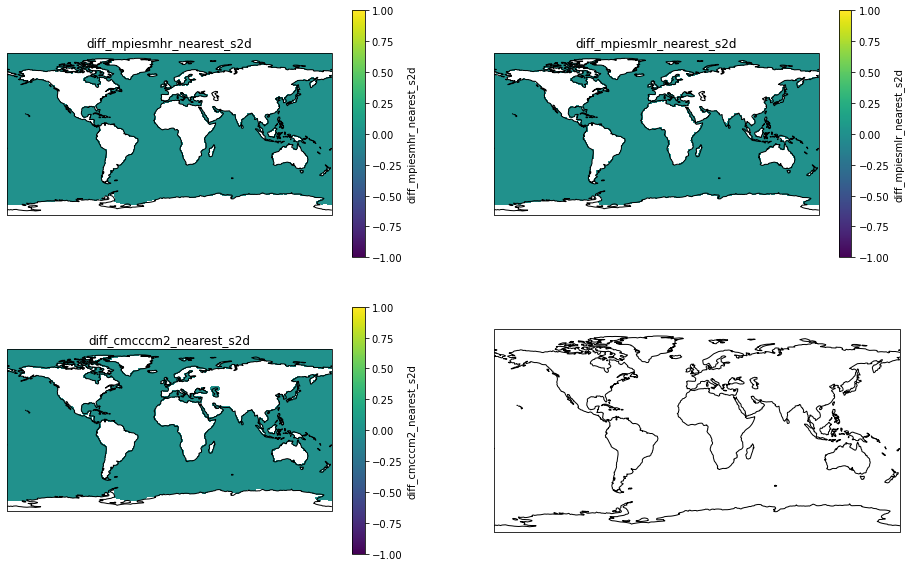

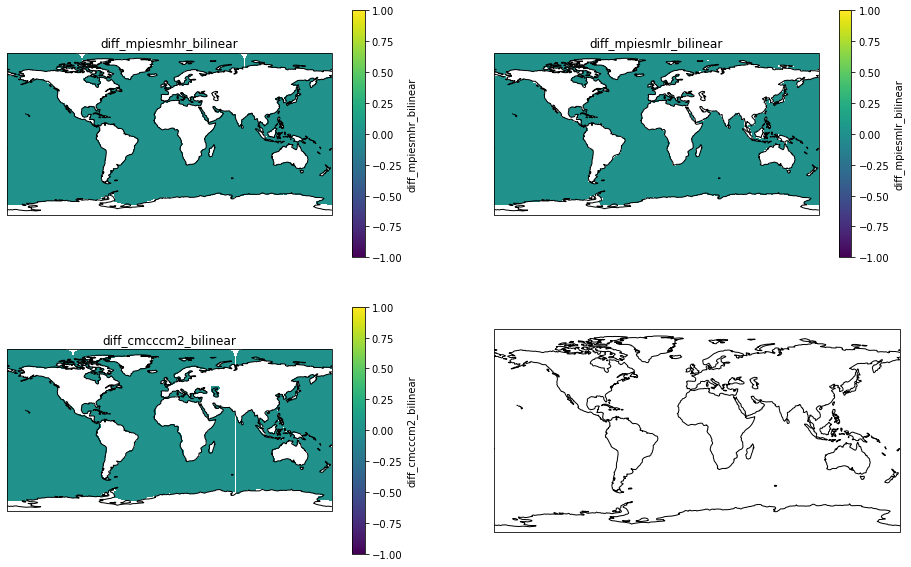

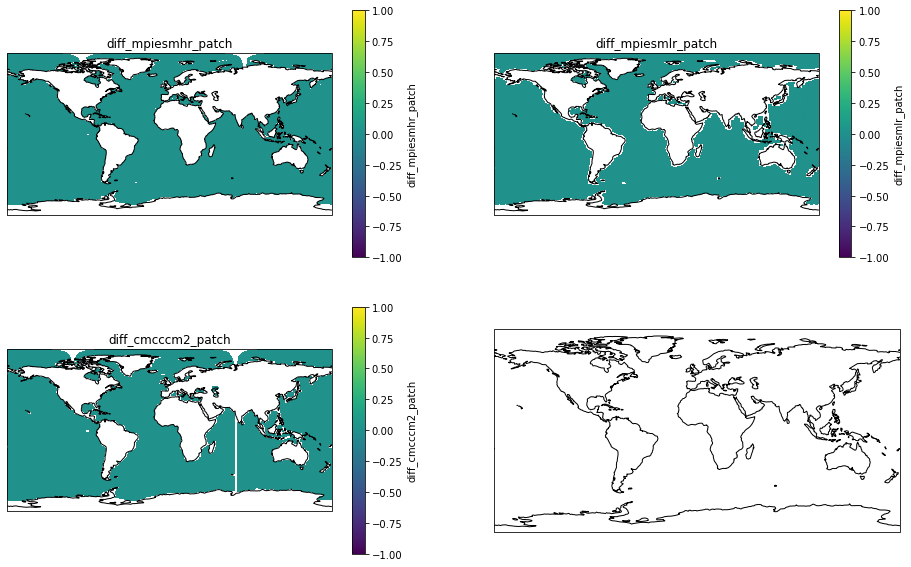

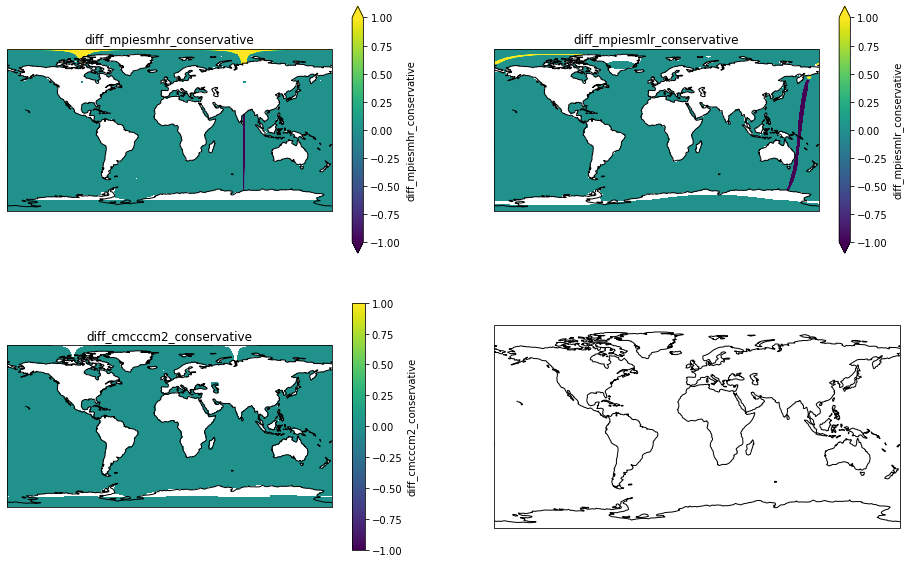

In [23]:
# Plot differences
for method in method_list:
    plot_3ds(ds_out, ["diff_mpiesmhr_"+method, "diff_mpiesmlr_"+method, "diff_cmcccm2_"+method])